In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import sklearn

import utils

import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('text.latex', preamble='''
        \\usepackage[utf8]{inputenc}
        \\usepackage{amssymb}
        \\usepackage{amsfonts}
        \\usepackage[russian]{babel}''')

In [3]:
metadata = pd.read_csv('../data/plasticc/plasticc_train_metadata.csv.gz')
data = pd.read_csv('../data/plasticc/plasticc_train_lightcurves.csv.gz')

data = data[data.detected_bool == 1]

In [4]:
data.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [5]:
object_ids = np.unique(data.object_id)

In [6]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

data["log_lam"] = data.apply(lambda x: passband2lam[x.passband], axis=1)

In [7]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

In [8]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [9]:
def create_approx_object(anobject, n=1000):
    mjd = anobject['mjd'].values
    dfs = []
    for passband in range(6):
        df = pd.DataFrame()
        df['mjd'] = np.linspace(mjd.min(), mjd.max(), n)
        df['object_id'] = 0
        df['passband'] = passband
        df['log_lam'] = passband2lam[passband]
        df['flux'] = 0
        df['flux_err'] = 0
        df['detected_bool'] = 1
        dfs.append(df)
    new_object = pd.concat(dfs, axis=0)
    return new_object

In [10]:
def is_good(anobject):
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        return False
    
    # keep only objects with at least 10 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 10:
            count += 1
    if count > 3:
        return False
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        return False
    
    return True

In [11]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, '-o', 
                    label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', fontsize=18)
    plt.xticks(fontsize=16)
    plt.ylabel('Flux', fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc='best', ncol=2, fontsize=16, columnspacing=1.0)
    plt.title(title, fontsize=20)

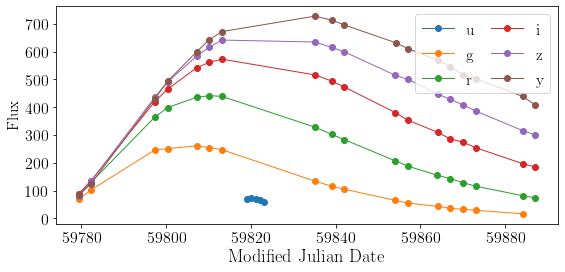

In [12]:
anobject = get_object(data, 34299)

plot_light_curves(anobject)

In [13]:
# train / test split
from sklearn.model_selection import train_test_split
anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

X_train = anobject_train[['mjd', 'log_lam']].values
X_test = anobject_test[['mjd', 'log_lam']].values

y_train = anobject_train['flux'].values
y_test  = anobject_test['flux'].values

from sklearn.preprocessing import StandardScaler
ss_x = StandardScaler()
X_train_ss = ss_x.fit_transform(X_train)
X_test_ss = ss_x.transform(X_test)

ss_y = StandardScaler()
y_train_ss = ss_y.fit_transform(y_train.reshape((-1, 1)))
y_test_ss = ss_y.transform(y_test.reshape((-1, 1)))

import single_layer_regressor

reg = single_layer_regressor.FitNNRegressor(n_hidden=125, n_epochs=300, batch_size=1, optimizer='SGD', lr=0.01)
reg.fit(X_train_ss, y_train_ss)

# predict flux for unseen observations
anobject_test_pred = anobject_test.copy()
res = ss_y.inverse_transform(reg.predict(X_test_ss))
anobject_test_pred['flux'] = np.maximum(res, np.zeros(len(res)))

# predict flux for known observations
anobject_train_pred = anobject_train.copy()
res = ss_y.inverse_transform(reg.predict(X_train_ss))
anobject_train_pred['flux'] = np.maximum(res, np.zeros(len(res)))

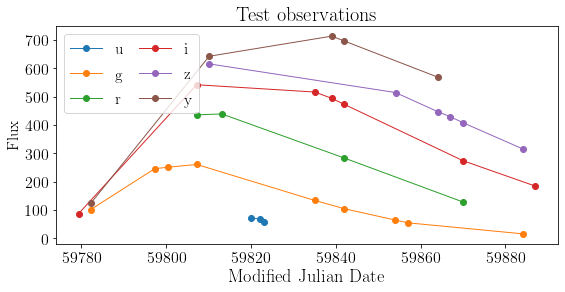

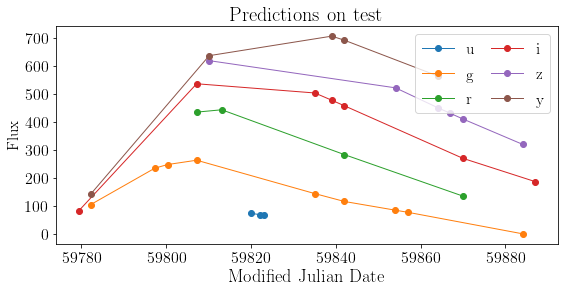

In [14]:
plot_light_curves(anobject_test, "Test observations")
plot_light_curves(anobject_test_pred, "Predictions on test")

In [15]:
# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'].values)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

RMSE:  9.207879586467547
MAE:  7.080347141314333
RSE:  0.04377234712477657
RAE:  0.03780574265440871
MAPE:  7.651913461457458


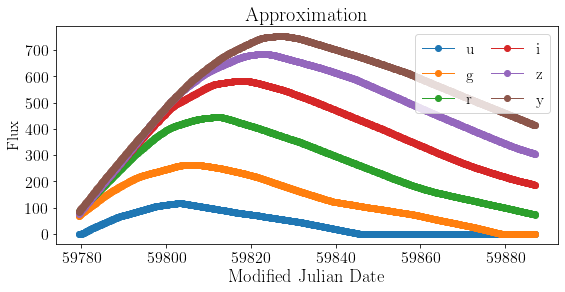

In [16]:
approx_object = create_approx_object(anobject)
x = approx_object.mjd
x_min = x.min()

X = approx_object[['mjd', 'log_lam']].values

X_ss = ss_x.transform(X)
res = ss_y.inverse_transform(reg.predict(X_ss))
approx_object['flux'] = np.maximum(res, np.zeros(len(res)))
plot_light_curves(approx_object, "Approximation")

In [17]:
good_objects = []
for i in object_ids:
    anobject = get_object(data, i)
#    anobject = add_log_lam(anobject)
    
    if is_good(anobject):
        good_objects.append(anobject)

In [18]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler

def test_model(n_hidden=10, n_epochs=100, batch_size=1, lr=0.01, optimizer='SGD'):
    metrics = []
    index = np.random.choice(len(good_objects), size=len(good_objects) // 5)
    for i in index:
        # get an object
        anobject = good_objects[i]

        # train / test split
        anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

        X_train = anobject_train[['mjd', 'log_lam']].values
        X_test  = anobject_test[['mjd', 'log_lam']].values

        y_train = anobject_train['flux'].values
        y_test  = anobject_test['flux'].values

        ss = StandardScaler()
        X_train_ss = ss.fit_transform(X_train)
        X_test_ss = ss.transform(X_test)

        ss_y = StandardScaler()
        y_train_ss = ss_y.fit_transform(y_train.reshape((-1, 1)))

        # fit a regression model to approximate light curves
        reg = single_layer_regressor.FitNNRegressor(n_hidden=n_hidden, 
                                                    n_epochs=n_epochs, 
                                                    batch_size=batch_size, 
                                                    lr=lr, 
                                                    optimizer=optimizer)
        reg.fit(X_train_ss, y_train_ss)

        # predict flux for unseen observations
        anobject_test_pred = anobject_test.copy()
        res = ss_y.inverse_transform(reg.predict(X_test_ss))
        anobject_test_pred['flux'] = np.maximum(res, np.zeros(len(res)))

        mape = mean_absolute_percentage_error(anobject_test['flux'].values, 
                                              anobject_test_pred['flux'].values)
        metrics.append(mape)
    return np.mean(metrics)

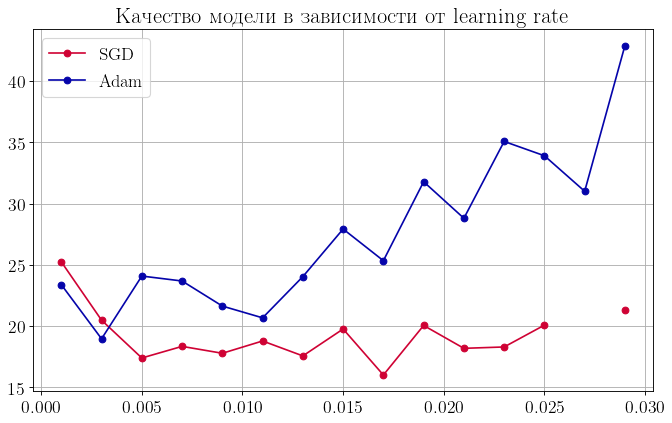

In [20]:
learning_rate = np.arange(0.001, 0.03, 0.002)
sgd_metrics = []
adam_metrics = []
sgd_lr = []
adam_lr = []

for lr in tqdm_notebook(learning_rate):
    try:
        sgd_mape = test_model(n_hidden=125, n_epochs=250, optimizer='SGD', lr=lr)
        sgd_metrics.append(sgd_mape)
        sgd_lr.append(lr)

        adam_mape = test_model(n_hidden=100, n_epochs=250, optimizer='Adam', lr=lr)
        adam_metrics.append(adam_mape)
        adam_lr.append(lr)
    except:
        continue
fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("Качество модели в зависимости от learning rate", fontsize=20)
plt.plot(sgd_lr, sgd_metrics, "-o", color="xkcd:cherry", label="SGD")
plt.plot(adam_lr, adam_metrics, "-o", color="xkcd:royal blue", label="Adam")
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/metrics_lr_one_layer.pdf")    

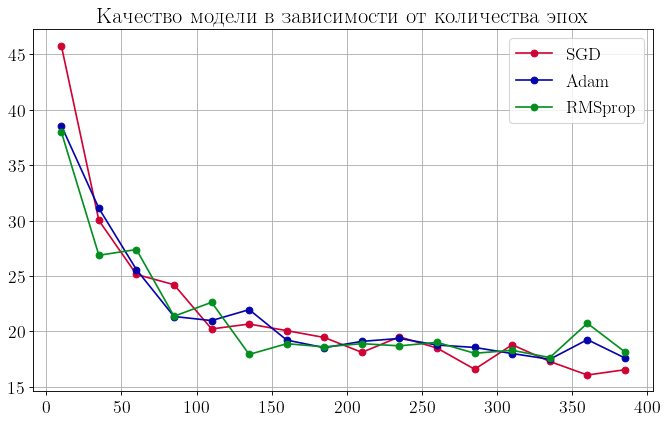

In [21]:
sgd_metrics = []
adam_metrics = []
RMSprop_metrics = []

epochs_range = np.arange(10, 401, 25)
for epochs in tqdm_notebook(epochs_range):
    adam_mape = test_model(n_hidden=100, n_epochs=epochs, optimizer='Adam', lr=0.001)
    adam_metrics.append(adam_mape)
    sgd_mape = test_model(n_hidden=100, n_epochs=epochs, optimizer='SGD')
    sgd_metrics.append(sgd_mape)
    RMSprop_mape = test_model(n_hidden=100, n_epochs=epochs, optimizer='RMSprop', lr=0.001)
    RMSprop_metrics.append(RMSprop_mape)
    
fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("Качество модели в зависимости от количества эпох", fontsize=20)
plt.grid(True)
plt.plot(epochs_range, sgd_metrics, "-o", color="xkcd:cherry", label="SGD")
plt.plot(epochs_range, adam_metrics, "-o", color="xkcd:royal blue", label="Adam")
plt.plot(epochs_range, RMSprop_metrics, "-o", color="xkcd:emerald green", label="RMSprop")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/metrics_nepochs_one_layer.pdf")

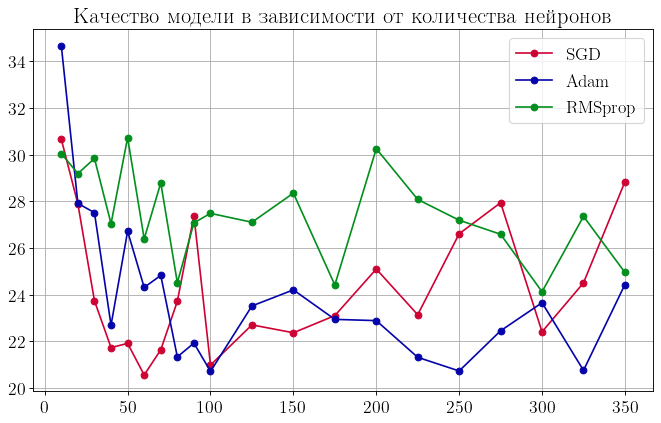

In [22]:
sgd_metrics = []
adam_metrics = []
RMSprop_metrics = []

neurons_range = np.concatenate((np.arange(10, 100, 10), np.arange(100, 351, 25)))
for n_hidden in tqdm_notebook(neurons_range):
    sgd_mape = test_model(n_hidden, optimizer='SGD')
    sgd_metrics.append(sgd_mape)
    adam_mape = test_model(n_hidden, optimizer='Adam', lr=0.001)
    adam_metrics.append(adam_mape)
    RMSprop_mape = test_model(n_hidden, optimizer='RMSprop')
    RMSprop_metrics.append(RMSprop_mape)
    
fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("Качество модели в зависимости от количества нейронов", fontsize=20)
plt.plot(neurons_range, sgd_metrics, "-o", color="xkcd:cherry", label="SGD")
plt.plot(neurons_range, adam_metrics, "-o", color="xkcd:royal blue", label="Adam")
plt.plot(neurons_range, RMSprop_metrics, "-o", color="xkcd:emerald green", label="RMSprop")
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/metrics_nhidden_one_layer.pdf")

In [24]:
anobject = get_object(data, 34299)

# fit augmentation model
model = single_layer_regressor.SingleLayerNetAugmentation(passband2lam)
model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['log_lam'].values)

# predict flux for unseen observations
flux_pred = model.predict(anobject_test['mjd'].values, anobject_test['log_lam'].values, copy=True)

# augmentation
t_aug, flux_aug, passbands_aug, log_lam_aug = model.augmentation(anobject['mjd'].min(), 
                                                                 anobject['mjd'].max(), n_obs=1000)

In [25]:
def compile_obj(t, flux, passband):
    obj = pd.DataFrame()
    obj['mjd']      = t
    obj['flux']     = flux
    obj['flux_err'] = np.array([None] * len(flux))
    obj['passband'] = passband
    return obj

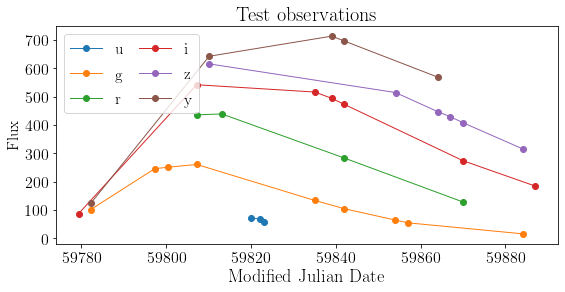

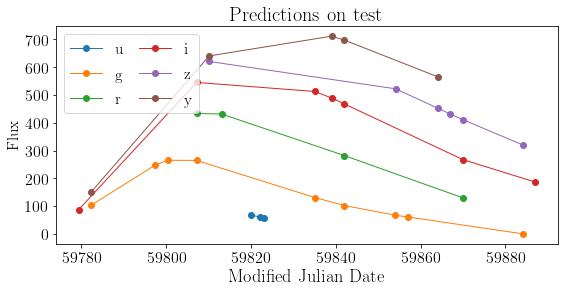

In [26]:
anobject_test_pred = compile_obj(anobject_test['mjd'].values, flux_pred, anobject_test['passband'].values)
anobject_aug = compile_obj(t_aug, flux_aug, passbands_aug)
plot_light_curves(anobject_test, "Test observations")
plot_light_curves(anobject_test_pred, "Predictions on test")

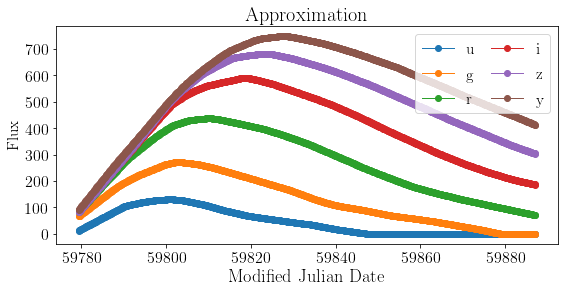

In [27]:
plot_light_curves(anobject_aug, "Approximation")

In [28]:
from tqdm import tqdm
from tqdm import tqdm_notebook

metrics = []
for i in tqdm_notebook(range(len(good_objects))):
    # get an object
    anobject = good_objects[i]

    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)
    
    # fit augmentation model
    model = single_layer_regressor.SingleLayerNetAugmentation(passband2lam)
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    # predict flux for unseen observations
    flux_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)
    anobject_test_pred = compile_obj(anobject_test['mjd'].values, flux_pred, anobject_test['passband'].values)

    metrics.append(mean_absolute_percentage_error(anobject_test['flux'].values, 
                                                  anobject_test_pred['flux'].values))

print(np.mean(metrics))


17.101405801979134
